To learn all of the pieces of the deep learning puzzle. This includes different types of layers, regularization methods, optimizers, how to put layers together into architectures, labeling techniques, and much more. 

In [1]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 194kB 8.2MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 


In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [ ]:
(path/"images").ls()

(#7393) [Path('images/english_cocker_spaniel_35.jpg'),Path('images/scottish_terrier_189.jpg'),Path('images/pomeranian_87.jpg'),Path('images/Abyssinian_141.jpg'),Path('images/saint_bernard_20.jpg'),Path('images/Abyssinian_100.mat'),Path('images/leonberger_96.jpg'),Path('images/newfoundland_92.jpg'),Path('images/Bombay_46.jpg'),Path('images/Persian_163.jpg')...]

Most functions and methods in fastai that return a collection use a class called L. L can be thought of as an enhanced version of the ordinary Python list type

In [ ]:
fname = (path/"images").ls()[0]
fname

Path('images/english_cocker_spaniel_35.jpg')

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['japanese_chin']

# labeling with regular expressions

For labeling with regular expressions, we can use the RegexLabeller

In [ ]:
get_image_files(path/"images")

(#7390) [Path('images/english_cocker_spaniel_35.jpg'),Path('images/scottish_terrier_189.jpg'),Path('images/pomeranian_87.jpg'),Path('images/Abyssinian_141.jpg'),Path('images/saint_bernard_20.jpg'),Path('images/leonberger_96.jpg'),Path('images/newfoundland_92.jpg'),Path('images/Bombay_46.jpg'),Path('images/Persian_163.jpg'),Path('images/Abyssinian_10.jpg')...]

In [4]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [ ]:
??using_attr

In [7]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/samoyed_186.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=334x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/samoyed_186.jpg
    applying partial gives
      samoyed
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(31)

Final sample: (PILImage mode=RGB size=334x500, TensorCategory(31))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_

## Presizing

* We need our images to have the same dimensions. GPU can process only of same dimension

fastai data augmentation strategy which we call presizing. Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

presizing adopts two strategies:

* **Resize images to relatively "large" dimensions**—that is, dimensions 
significantly larger than the target training dimensions.
* Compose all of the common augmentation operations (including a resize to the final target size) into one, and **perform the combined operation on the GPU only once at the end of processing**, rather than performing the operations individually and interpolating multiple times.

* **Crop full width or height:** This is in item_tfms, so it's applied to each individual image before it is copied to the GPU. It's used to ensure all images are the same size. On the training set, the crop area is chosen randomly. On the validation set, the center square of the image is always chosen.
* **Random crop and augment:** This is in batch_tfms, so it's applied to a batch all at once on the GPU, which means it's fast. On the validation set, only the resize to the final size needed for the model is done here. On the training set, the random crop and any other augmentations are done first.

In [ ]:
parent_label(fname)

'images'

In [ ]:
Path.cwd()

Path('/content')

In [ ]:
[(Path.cwd()/'images'/'grizzly.jpg')]*5

[Path('/content/images/grizzly.jpg'),
 Path('/content/images/grizzly.jpg'),
 Path('/content/images/grizzly.jpg'),
 Path('/content/images/grizzly.jpg'),
 Path('/content/images/grizzly.jpg')]

In [ ]:
?Inf

In [ ]:
Inf.ones

In [ ]:
#augmentation ny fastai
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(path/"images"/"english_cocker_spaniel_35.jpg")]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones

In [ ]:
dls1.train.get_idxs

<function __main__.<lambda>>

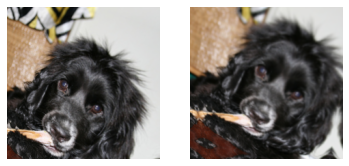

In [ ]:
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

# augmentation by pytorch
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0]) 
TensorImage(x1[0]).show(ctx=axs[1]);

# Debugging datablock

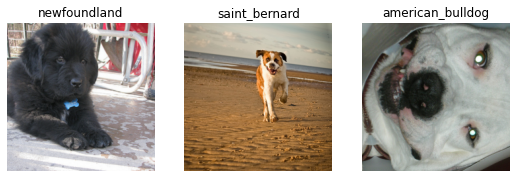

In [8]:
dls.show_batch(nrows=1, ncols=3)

one common mistake is to forget to use a Resize transform, so you end up with pictures of different sizes and are not able to batch them.

In [ ]:
pets.summary(path/"images")

In [5]:
# creating a baseline
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.455649,0.345657,0.108254,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.493537,0.339309,0.105548,01:07
1,0.329375,0.251095,0.077808,01:06


an epoch is one complete pass through all of the images in the data.

# Cross-Entropy Loss

* It works even when our dependent variable has more than two categories.
* It results in faster and more reliable training.

to understand how cross-entropy loss works for dependent variables with more than two categories, we first have to understand what the actual data and activations that are seen by the loss function look like.

## Viewing Activations and Labels

In [11]:
# get one batch from the dataloader
x,y = dls.one_batch()

In [13]:
??dls.one_batch()

In [7]:
# predictions
y
#Each row is a single integer between 0 and 36, representing our 37 possible pet breeds.

TensorCategory([ 1, 16, 15, 33,  2, 15,  5, 12, 21, 27, 35, 33, 21, 23, 35, 34, 30,  2,
         3, 19, 14, 20, 11, 32,  4, 14, 29,  5, 34,  3,  6, 12, 24, 26, 16, 31,
        33, 31, 29,  3, 10,  4, 11, 11, 34,  9, 12, 35, 17, 26, 11, 33,  8, 27,
         5, 20, 30, 20, 10, 36, 30, 18, 30, 29], device='cuda:0')

In [8]:
#The predictions (that is, the activations of the final layer of our neural network) using Learner.get_preds
preds,_ = learn.get_preds(dl=[(x,y)])
len(preds)

64

In [9]:
#the values in final layer of activation
preds[0]

tensor([6.0319e-04, 9.9545e-01, 2.2044e-06, 1.0781e-06, 4.1424e-05, 2.6870e-03,
        2.9103e-04, 1.5272e-06, 4.6056e-06, 8.4923e-05, 2.8137e-06, 7.3274e-04,
        8.2415e-08, 8.8395e-07, 4.8222e-05, 2.9086e-06, 9.5135e-07, 6.6032e-07,
        7.3066e-06, 6.9251e-06, 5.3558e-06, 3.4199e-06, 2.0654e-07, 2.2824e-06,
        3.9817e-07, 2.9050e-06, 5.1128e-06, 1.2416e-06, 4.6747e-07, 3.6898e-07,
        7.8147e-07, 7.2595e-07, 4.5833e-06, 2.1178e-06, 1.8918e-07, 1.1556e-06,
        2.7736e-06])

In [14]:
# total values will be adding to 1
preds[0].sum()

tensor(1.0000)

## Softmax

In our classification model, we use the softmax activation function in the final layer to ensure that the activations are all between 0 and 1, and that they sum to 1.

In [15]:
# use some random numbers with a standard deviation of 2 (so we multiply randn by 2) 
#for this example, assuming we have 6 images and 2 possible categories
acts = torch.randn((6,2))*2
acts

tensor([[-0.9916, -2.2545],
        [ 0.1560, -1.9368],
        [-0.6164,  1.1047],
        [-2.0798, -2.1778],
        [ 1.6429, -3.7728],
        [-1.2445, -2.9512]])

In [16]:
acts.min(),acts.max()

(tensor(-3.7728), tensor(1.6429))

In [23]:
#std deviation
#measure of the amount of variation or dispersion of a set of values. 
#A low standard deviation indicates that the values tend to be close to the mean of the set, 
#while a high standard deviation indicates that the values are spread out over a wider range. 

((((acts-acts.mean())**2).sum())/len(acts)).sqrt()

tensor(2.1850)

In [ ]:
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)

A single pair of activations simply indicates the relative confidence of the input being a 3 versus being a 7. The overall values, whether they are both high, or both low, don't matter—all that matters is which is higher, and by how much.

In [25]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.7795, 0.8902, 0.1517, 0.5245, 0.9956, 0.8464])

In [26]:
(-acts[:,0]+acts[:,1]).sigmoid()

tensor([0.2205, 0.1098, 0.8483, 0.4755, 0.0044, 0.1536])

In [24]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts
# dim =1 --> subract column wise

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

softmax is the multi-category equivalent of sigmoid—we have to use it any time we have more than two categories and the probabilities of the categories must add to 1, and we often use it even when there are just two categories, just to make things a bit more consistent. 

In [29]:
torch.randn((1,5))

tensor([[2.1609, 1.1302, 1.3140, 0.2729, 0.5357]])

## Log Likelihood

In [30]:
targ = tensor([0,1,0,1,1,0])

In [31]:
sm_acts

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

In [32]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.7795, 0.1098, 0.1517, 0.4755, 0.0044, 0.8464])

We're only picking the loss from the column containing the correct label. We don't need to consider the other columns

PyTorch provides a function that does exactly the same thing as sm_acts[range(n), targ] (except it takes the negative, because when applying the log afterward, we will have negative numbers), called nll_loss (NLL stands for negative log likelihood):



In [33]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.7795, -0.1098, -0.1517, -0.4755, -0.0044, -0.8464])

## log

0.999 is 10 times more confident than 0.99. So, we want to transform our numbers between 0 and 1 to instead be between negative infinity and infinity. There is a mathematical function that does exactly this: the logarithm (available as torch.log). It is not defined for numbers less than 0

log in Python uses the special number e (2.718...) as the base.



```
y = b**a
a = log(y,b)
```

logarithms increase linearly when the underlying signal increases exponentially or multiplicatively. This is used, for instance, in the Richter scale of earthquake severity, and the dB scale of noise levels. It's also often used on financial charts, where we want to show compound growth rates more clearly. Computer scientists love using logarithms, because it means that multiplication, which can create really really large and really really small numbers, can be replaced by addition, which is much less likely to result in scales that are difficult for our computers to handle.
```
log(a*b) = log(a)+log(b)
```

Logarithms are widely used in physics, for multiplying very big or very small numbers, and many other fields.


The nll in nll_loss stands for "negative log likelihood," but it doesn't actually take the log at all! It assumes you have already taken the log. PyTorch has a function called log_softmax that combines log and softmax in a fast and accurate way. nll_loss is designed to be used after log_softmax.

first take the softmax, and then the log likelihood of that, that combination is called cross-entropy loss. In PyTorch, this is available as nn.CrossEntropyLoss (which, in practice, actually does log_softmax and then nll_loss)

In [35]:
loss_func = nn.CrossEntropyLoss()

In [36]:
loss_func(acts, targ)

tensor(1.7790)

In [37]:
#By default PyTorch loss functions take the mean of the loss of all items. You can use reduction='none' to disable that
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.2491, 2.2091, 1.8857, 0.7434, 5.4201, 0.1667])

An interesting feature about cross-entropy loss appears when we consider its gradient. The gradient of cross_entropy(a,b) is just softmax(a)-b. Since softmax(a) is just the final activation of the model, that means that the gradient is proportional to the difference between the prediction and the target. This is the same as mean squared error in regression (assuming there's no final activation function such as that added by y_range), since the gradient of (a-b)**2 is 2*(a-b). Because the gradient is linear, that means we won't see sudden jumps or exponential increases in gradients, which should lead to smoother training of models.

# Model Interpretation

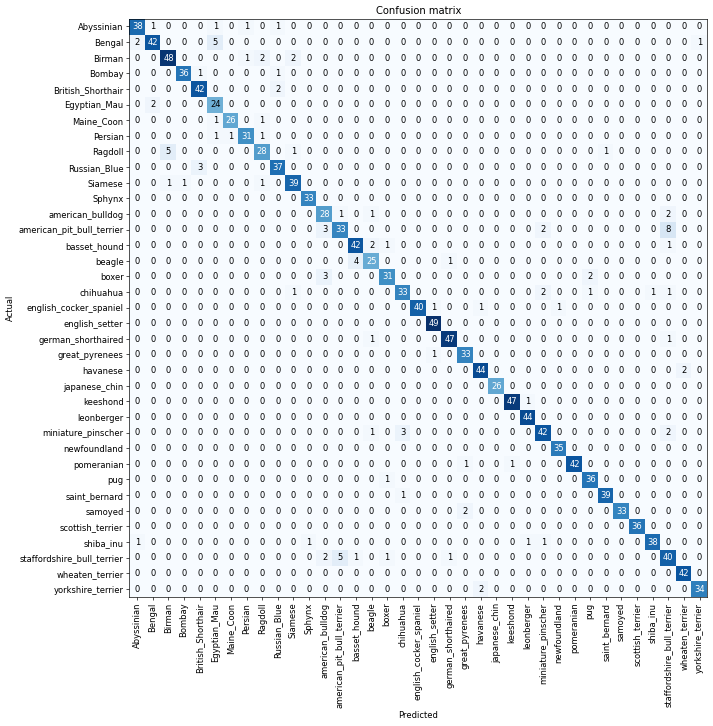

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [40]:
interp.preds

tensor([[6.0096e-08, 3.0282e-07, 1.5199e-07,  ..., 2.0719e-08, 2.7700e-06,
         5.7307e-08],
        [2.8047e-06, 1.4765e-08, 5.5411e-08,  ..., 1.8758e-07, 1.9849e-07,
         4.7635e-08],
        [1.0607e-06, 3.0336e-06, 2.6628e-06,  ..., 6.2554e-06, 9.7338e-01,
         9.4302e-06],
        ...,
        [2.3317e-10, 1.1200e-09, 1.2904e-11,  ..., 9.9074e-12, 1.0000e+00,
         1.6680e-11],
        [8.4088e-07, 4.1624e-04, 7.0599e-09,  ..., 2.8023e-09, 1.0903e-09,
         2.2047e-09],
        [1.4482e-04, 7.7934e-01, 8.2312e-07,  ..., 2.8886e-07, 7.6662e-07,
         1.4943e-05]])

In [42]:
interp.preds[0]

tensor([6.0096e-08, 3.0282e-07, 1.5199e-07, 2.0760e-08, 4.5530e-09, 5.5961e-08,
        4.0332e-06, 8.6464e-09, 3.0461e-08, 6.1353e-08, 3.0337e-08, 1.8451e-08,
        3.5489e-08, 3.9413e-08, 1.9527e-06, 1.0580e-08, 1.4371e-06, 1.6522e-08,
        1.1756e-07, 4.2918e-07, 3.7050e-07, 7.2433e-05, 1.7007e-07, 1.0472e-07,
        2.9058e-05, 9.9974e-01, 2.1055e-08, 9.5200e-05, 2.3725e-08, 1.0781e-07,
        5.5452e-05, 8.9601e-08, 7.4899e-09, 1.6372e-08, 2.0719e-08, 2.7700e-06,
        5.7307e-08])

In [43]:
interp.preds[0][25]

tensor(0.9997)

In [44]:
interp.preds[0].max()

tensor(0.9997)

In [45]:
interp.preds[0].sum()

tensor(1.0000)

In [41]:
interp.targs

tensor([25, 33, 35,  ..., 35,  5,  5])

In [46]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Ragdoll', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5)]

# Improving Our Model

The first thing we need to set when training a model is the learning rate.

## The Learning Rate Finder

In [47]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.565958,4.107076,0.428281,01:06


epoch,train_loss,valid_loss,error_rate,time
0,4.447203,3.437598,0.874154,01:09


We use that for one mini-batch, find what the losses are afterwards, and then increase the learning rate by some percentage (e.g., doubling it each time). Then we do another mini-batch, track the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This is the point where we know we have gone too far. We then select a learning rate a bit lower than this point. Our advice is to pick either:

* One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
* The last point where the loss was clearly decreasing

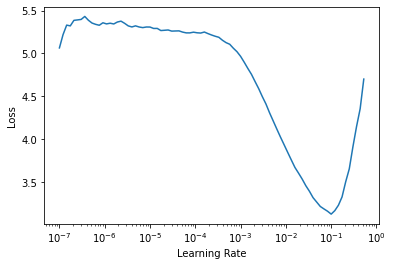

In [48]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [49]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 3.63e-03


In [50]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.300092,0.341122,0.107578,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.528658,0.376798,0.111637,01:08
1,0.334181,0.257829,0.075101,01:08


## Unfreezing and Transfer Learning

fine_tune method fastai does two things:

* Trains the randomly added layers for one epoch, with all other layers frozen
* Unfreezes all of the layers, and trains them all for the number of epochs requested


First of all we will train the randomly added layers for three epochs, using fit_one_cycle. As mentioned in <>, fit_one_cycle is the suggested way to train models without using fine_tune. We'll see why later in the book; in short, what fit_one_cycle does is to start training at a low learning rate, gradually increase it for the first section of training, and then gradually decrease it again for the last section of training.



In [51]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.139216,0.374060,0.110284,01:06
1,0.526753,0.276369,0.080514,01:06
2,0.327841,0.241023,0.073072,01:06


In [52]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.311311274956097e-06)

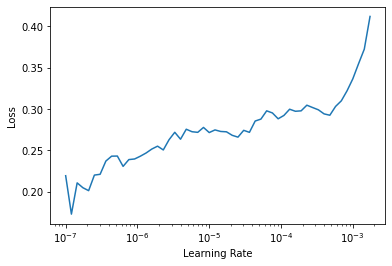

In [53]:
learn.lr_find()

In [54]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.251593,0.229324,0.070365,01:09
1,0.248510,0.217998,0.067659,01:09
2,0.233130,0.213455,0.067659,01:10
3,0.196017,0.205835,0.059540,01:10
4,0.194585,0.203892,0.062246,01:09
5,0.184385,0.203398,0.063599,01:08


## Discriminative Learning Rates

use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers). 

In [55]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.170594,0.318610,0.102842,01:06
1,0.536567,0.273771,0.081867,01:06
2,0.321517,0.247104,0.074425,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.268112,0.237597,0.073072,01:10
1,0.252420,0.228559,0.069689,01:09
2,0.232054,0.226593,0.069689,01:09
3,0.223201,0.219989,0.067659,01:09
4,0.184803,0.215022,0.061570,01:09
5,0.165913,0.213125,0.062923,01:09
6,0.147007,0.207047,0.061570,01:09
7,0.153080,0.209925,0.061570,01:09
8,0.134653,0.211636,0.062246,01:08
9,0.133380,0.210718,0.061570,01:09


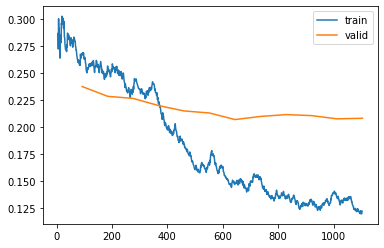

In [56]:
learn.recorder.plot_loss()

# Selecting the Number of Epochs

he metrics you have chosen are really getting worse at the end of training. Remember, it's not just that we're looking for the validation loss to get worse, but the actual metrics. Your validation loss will first get worse during training because the model gets overconfident, and only later will get worse because it is incorrectly memorizing the data. We only care in practice about the latter issue. Remember, our loss function is just something that we use to allow our optimizer to have something it can differentiate and optimize; it's not actually the thing we care about in practice.

Before the days of 1cycle training it was very common to save the model at the end of each epoch, and then select whichever model had the best accuracy out of all of the models saved in each epoch. This is known as early stopping. However, this is very unlikely to give you the best answer, because those epochs in the middle occur before the learning rate has had a chance to reach the small values, where it can really find the best result. Therefore, if you find that you have overfit, what you should actually do is retrain your model from scratch, and this time select a total number of epochs based on where your previous best results were found.



# Deeper Architectures

In general, a model with more parameters can model your data more accurately.

In general, a bigger model has the ability to better capture the real underlying relationships in your data, and also to capture and memorize the specific details of your individual images.

However, using a deeper model is going to require more GPU RAM, so you may need to lower the size of your batches to avoid an *out-of-memory error*. This happens when you try to fit too much inside your GPU and looks like:

```
Cuda runtime error: out of memory
```

You may have to restart your notebook when this happens. The way to solve it is to use a smaller batch size, which means passing smaller groups of images at any given time through your model. You can pass the batch size you want to the call creating your `DataLoaders` with `bs=`.

The other downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is *mixed-precision training*. This refers to using less-precise numbers (*half-precision floating point*, also called *fp16*) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called *tensor cores* that can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add `to_fp16()` after your `Learner` creation (you also need to import the module).


In [57]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.433252,0.346421,0.110284,01:10
1,0.605509,0.362344,0.110284,01:07
2,0.418018,0.340712,0.098106,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.253891,0.287615,0.085250,01:08
1,0.284394,0.405249,0.110961,01:08
2,0.265305,0.334716,0.089310,01:08
3,0.164134,0.245209,0.067659,01:07
4,0.097326,0.217829,0.061570,01:07
5,0.060512,0.211600,0.062923,01:07
